<a href="https://colab.research.google.com/github/Akanerd/ComputerVision-Orbit/blob/main/YOLOv4_tiny_Darknet_Mask_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Open In Colab](https://colab.research.google.com/github/ibaiGorordo/Social-Distance-Feedback/blob/master/Part%202%20-%20Mask%20Detection/Face%20Mask%20Detection%20Inference%20Comparison/YOLOv4_tiny_Darknet_Mask_Detection.ipynb)

# DepthAI Tutorial: Training a Tiny YOLOv4 Object Detector with Your Own Data

<img src="https://docs.luxonis.com/images/depthai_logo.png" width="500">

Welcome to DepthAI! 

In this tutorial we will train an object detector using the Tiny Yolo v4 model. This model will run on our DepthAI Myriad X modules.

The model is pretrained on the COCO dataset. The framework used for training is Darknet.
Will run through the following steps:


*   Install the libraries (Darknet , etc.)
*   Clone the github repo and replace the repo training data with your data (from google drive or from own repo - which is faster)
*   Train the model on the new images
*   Run inference on a few images to see what the model can detect
*   Convert the model to OpenVINO Intermediate Representation
*   To run the model on DepthAI modules, compile the IR obtained above to a .blob file 

You can make a copy of this tutorial: File-> Save a copy in Drive

Note: the model training can be run with the repo images of medical masks if you choose to skip the customization part for your own images just to see how the training and the rest of the steps work

In [ ]:
# verify CUDA
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [ ]:
#take a look at the kind of GPU we have
!nvidia-smi

Tue Apr  5 04:26:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Installing Darknet for YOLOv4 on Colab




In [ ]:
%cd /content/
%rm -rf darknet

/content


In [ ]:
# clone darknet repo
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15412, done.
remote: Total 15412 (delta 0), reused 0 (delta 0), pack-reused 15412
Receiving objects: 100% (15412/15412), 14.02 MiB | 17.81 MiB/s, done.
Resolving deltas: 100% (10356/10356), done.


In [ ]:
# change makefile to have GPU and OPENCV enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile

/content/darknet


**IMPORTANT! If you're not using a K80 GPU, then uncomment the sed command and replace the arch and code with that matching your GPU. A list can be found [here](http://arnon.dk/matching-sm-architectures-arch-and-gencode-for-various-nvidia-cards/).**

In [ ]:
#install environment from the Makefile
%cd darknet/
# compute_30, sm_30 for Tesla K80
# compute_75, sm_75 for Tesla T4
# !sed -i 's/ARCH= -gencode arch=compute_60,code=sm_60/ARCH= -gencode arch=compute_30,code=sm_30/g' Makefile

#install environment from the Makefile
#note if you are on Colab Pro this works on a P100 GPU
#if you are on Colab free, you may need to change the Makefile for the K80 GPU
#this goes for any GPU, you need to change the Makefile to inform darknet which GPU you are running on.
!make

[Errno 2] No such file or directory: 'darknet/'
/content/darknet
mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [

## Clone a helper repo
It makes training the medical mask detecting model easy.
In order to train on your own data, this repo can be used as a blueprint. 
Changes to some files need to be made according to own data, but it is nothing complicated.

In [ ]:
repo_url = 'https://github.com/GotG/yolotinyv3_medmask_demo'
import os
%cd /content
repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))
!git clone {repo_url}
%cd {repo_dir_path}


/content
Cloning into 'yolotinyv3_medmask_demo'...
remote: Enumerating objects: 1733, done.
remote: Total 1733 (delta 0), reused 0 (delta 0), pack-reused 1733
Receiving objects: 100% (1733/1733), 208.88 MiB | 29.56 MiB/s, done.
Resolving deltas: 100% (120/120), done.
Checking out files: 100% (1537/1537), done.
/content/yolotinyv3_medmask_demo


In [ ]:
#define utility function
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  #plt.rcParams['figure.figsize'] = [10, 5]
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

## Change the labels in obj.names to our current labels

In [ ]:
labels_path = '/content/yolotinyv3_medmask_demo/obj.names'
#make a list of your labels
labels = ['mask','no mask']
# labels = ['good','bad']

with open(labels_path, 'w') as f:

    f.write('\n'.join(labels))

#check that the labels file is correct
!cat /content/yolotinyv3_medmask_demo/obj.names

mask
no mask

## Change the number of classes in obj.data.
The paths are relative so no change there as long as the folder/file structure/names are not changed.

In [ ]:
import re
objdata = '/content/yolotinyv3_medmask_demo/obj.data'
with open(objdata) as f:
    s = f.read()

#the number of classes is equal to the number of labels
num_classes = len(labels)   
s = re.sub('classes = \d*','classes = ' + str(num_classes),s)

with open(objdata, 'w') as f:
  f.write(s)
!cat /content/yolotinyv3_medmask_demo/obj.data

classes= 2
train  = /content/yolotinyv3_medmask_demo/train.txt
valid  = /content/yolotinyv3_medmask_demo/valid.txt
names = /content/yolotinyv3_medmask_demo/obj.names
backup = backup/

### Now that we see which parameters are of importance, let's modify them according to our dataset.

In [ ]:
# set the number of max_batches - min 2000 per class:
max_batch=4000
# calculate the 2 steps values:
step1 = 0.8 * max_batch
step2 = 0.9 * max_batch

# we also need to adjust the number of classes and a parameter called filter size 
# that are both is inside the model structure

# num_classes = len(labels)
num_filters = (num_classes + 5) * 3


#cfg_file = '/content/yolotinyv3_medmask_demo/yolov3-tiny_obj.cfg'
cfg_file = '/content/yolotinyv3_medmask_demo/yolov4-tiny.cfg'

with open(cfg_file) as f:
    s = f.read()
# (re.sub('[a-z]*@', 'ABC@', s))
s = re.sub('max_batches = \d*','max_batches = '+str(max_batch),s)
s = re.sub('steps=\d*,\d*','steps='+"{:.0f}".format(step1)+','+"{:.0f}".format(step2),s)
s = re.sub('classes=\d*','classes='+str(num_classes),s)
s = re.sub('pad=1\nfilters=\d*','pad=1\nfilters='+"{:.0f}".format(num_filters),s)
# pad=1\nfilters=\d\d
# s = re.sub('CUDNN=0','CUDNN=1',s)
# s = re.sub('OPENCV=0','OPENCV=1',s)

with open(cfg_file, 'w') as f:
  # s = re.sub('GPU=0','GPU=1',s)
  f.write(s)


## Start the model training

In [ ]:
%cd ../darknet/
!./darknet detector train /content/yolotinyv3_medmask_demo/obj.data /content/yolotinyv3_medmask_demo/yolov4-tiny.cfg /content/yolotinyv3_medmask_demo/yolov4-tiny.conv.29 -dont_show -ext_output -map

Streaming output truncated to the last 5000 lines.

 (next mAP calculation at 3400 iterations) 
 Last accuracy mAP@0.50 = 86.42 %, best = 86.42 % ]2;3396/4000: loss=0.3 map=0.86 best=0.86 hours left=0.2
 3396: 0.321030, 0.220685 avg loss, 0.000261 rate, 0.931657 seconds, 217344 images, 0.240161 hours left
Loaded: 0.110366 seconds - performance bottleneck on CPU or Disk HDD/SSD
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.862924), count: 28, class_loss = 0.056720, iou_loss = 0.232155, total_loss = 0.288875 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.830819), count: 239, class_loss = 0.542433, iou_loss = 22.308249, total_loss = 22.850681 
 total_bbox = 803977, rewritten_bbox = 0.041046 % 

 (next mAP calculation at 3400 iterations) 
 Last accuracy mAP@0.50 = 86.42 %, best = 86.42 % ]2;3397/4000: loss=0.3 map=0.86 best=0.86 hours left=0.2
 3397: 0.299744, 0.228591 avg loss, 0.000261 rate, 1.045101 seconds, 217

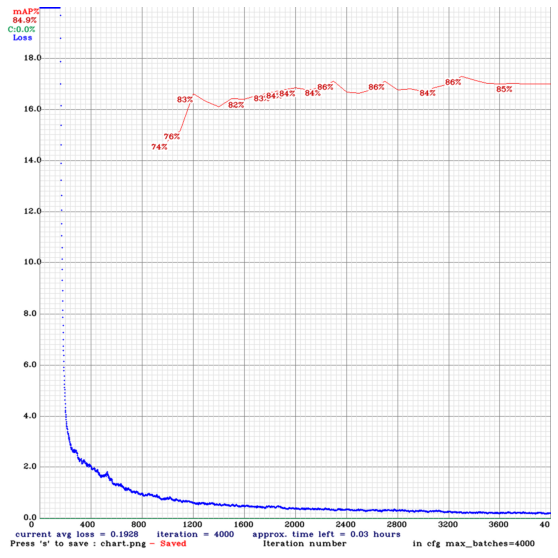

In [ ]:
imShow("chart_yolov4-tiny.png")

## Check the model performance
The metrics run on the test images so they may not be fully representative, only indicative

In [ ]:
!./darknet detector map /content/yolotinyv3_medmask_demo/obj.data /content/yolotinyv3_medmask_demo/yolov4-tiny.cfg "/content/darknet/backup/yolov4-tiny_best.weights" -points 0

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 2    416 x 416 x   3 ->  208 x 208 x  32 0.075 BF
   1 conv     64       3 x 3/ 2    208 x 208 x  32 ->  104 x 104 x  64 0.399 BF
   2 conv     64       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.797 BF
   3 route  2 		                       1/2 ->  104 x 104 x  32 
   4 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   5 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   6 route  5 4 	                           ->  104 x 104 x  64 
   7 conv     64       1 x 1/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.089 BF
   8 route  2 7 	    

## Run detection on an image. I choose one of the test images from test.txt

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 2    416 x 416 x   3 ->  208 x 208 x  32 0.075 BF
   1 conv     64       3 x 3/ 2    208 x 208 x  32 ->  104 x 104 x  64 0.399 BF
   2 conv     64       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.797 BF
   3 route  2 		                       1/2 ->  104 x 104 x  32 
   4 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   5 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   6 route  5 4 	                           ->  104 x 104 x  64 
   7 conv     64       1 x 1/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.089 BF
   8 route  2 7 	    

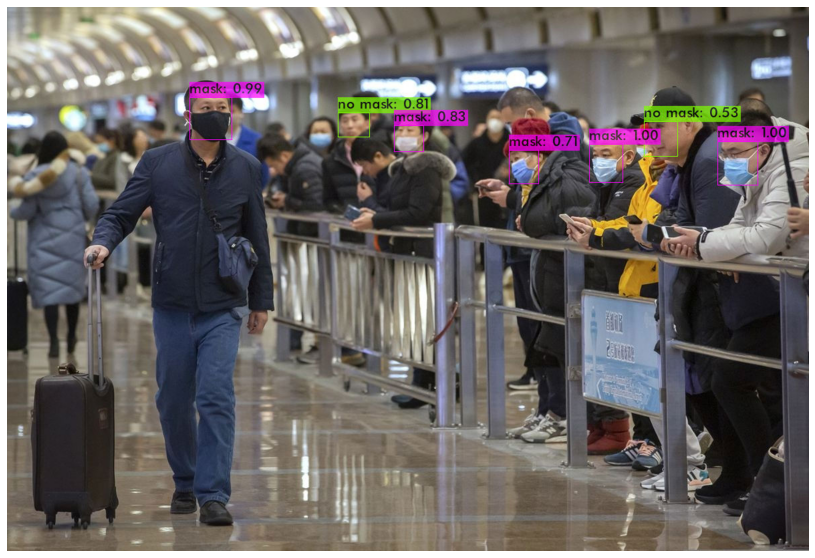

In [ ]:
!./darknet detector test /content/yolotinyv3_medmask_demo/obj.data  /content/yolotinyv3_medmask_demo/yolov4-tiny.cfg  "/content/darknet/backup/yolov4-tiny_best.weights" /content/yolotinyv3_medmask_demo/obj/0633.jpg -ext_output
imShow('predictions.jpg')

# Step 7: Running YOLOv4 on Video in the Cloud!

You can also run YOLOv4 object detections on video in your Google Colab VM. Follow the cells below to see how to run videos from your local machine or from your Google Drive! 

## Local Machine Video
Here is how to upload video from local machine, run detector and then download video showing detections.

In [ ]:
!wget -O test.mp4 "https://github.com/ibaiGorordo/Social-Distance-Feedback/raw/master/Part%202%20-%20Mask%20Detection/Face%20Mask%20Detection%20Inference%20Comparison/videos/production%20ID_4236787.mp4"

--2022-04-05 05:50:51--  https://github.com/ibaiGorordo/Social-Distance-Feedback/raw/master/Part%202%20-%20Mask%20Detection/Face%20Mask%20Detection%20Inference%20Comparison/videos/production%20ID_4236787.mp4
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/ibaiGorordo/Social-Distance-Feedback-For-The-Blind/raw/master/Part%202%20-%20Mask%20Detection/Face%20Mask%20Detection%20Inference%20Comparison/videos/production%20ID_4236787.mp4 [following]
--2022-04-05 05:50:51--  https://github.com/ibaiGorordo/Social-Distance-Feedback-For-The-Blind/raw/master/Part%202%20-%20Mask%20Detection/Face%20Mask%20Detection%20Inference%20Comparison/videos/production%20ID_4236787.mp4
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ibaiGorordo/Social-Distance-

In [ ]:
!./darknet detector demo /content/yolotinyv3_medmask_demo/obj.data  /content/yolotinyv3_medmask_demo/yolov4-tiny.cfg  "/content/darknet/backup/yolov4-tiny_best.weights" -dont_show test.mp4 -i 0 -out_filename results.avi

In [ ]:
# download the video with detections shown
from google.colab import files

video_path = 'results.avi'
files.download(video_path)